In [13]:
import networkx as nx
import random
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.stats import uniform 
import pandas as pd

### Create network

In [14]:
def area(radii, heights):
    return np.sum(0.5 * (2 * np.array(radii)) * heights)

def objective(params, radii):
    k = params[0]
    heights = k * np.array(radii)
    return np.abs(area(radii, heights) - 1)

def calculate_radii(L, max_x):
    radii = []
    for i, x_peak in enumerate(L):
        
        if (len(L) > 1):
            if i == 0:
                left_distance = min((x_peak - L[-1]) % max_x, (L[-1] - x_peak) % max_x)
            else:
                left_distance = min((x_peak - L[i - 1]) % max_x, (L[i - 1] - x_peak) % max_x)

            if i == len(L) - 1:
                right_distance = min((L[0] - x_peak) % max_x, (x_peak - L[0]) % max_x)
            else:
                right_distance = min((L[i + 1] - x_peak) % max_x, (x_peak - L[i + 1]) % max_x)

            radius = min(left_distance, right_distance) // 2  
        else:
            radius = int(max_x/2)
            
        radii.append(radius)
    return radii

def construct_tents(x_values, L, radii, k):
    y_values = np.zeros_like(x_values, dtype=float)
    heights = k * np.array(radii)
    
    for i, x_peak in enumerate(L):
        left_boundary = x_peak - radii[i]
        right_boundary = x_peak + radii[i]
        
        left_slope = heights[i] / radii[i]
        right_slope = heights[i] / radii[i]

        if left_boundary >= 0:
            y_values[left_boundary:x_peak] = left_slope * (x_values[left_boundary:x_peak] - left_boundary)
        else:                
            remaining_distance = 0 - left_boundary        
            y_values[:x_peak] = left_slope * (x_values[:x_peak] - left_boundary)     
            y_values[left_boundary:] = left_slope * (x_values[left_boundary:] - (len(x_values) - remaining_distance))
            

        if right_boundary <= len(x_values):
            y_values[x_peak:right_boundary] = right_slope * (right_boundary - x_values[x_peak:right_boundary])
        else:
            remaining_distance = right_boundary - len(x_values)
            y_values[x_peak:] = right_slope * (right_boundary - x_values[x_peak:])
            y_values[0:remaining_distance] = right_slope * (right_boundary - len(x_values) - x_values[0:remaining_distance])
 
    return y_values

In [15]:
def construct_tents_uniform(x_values):
    y_values = np.full(len(x_values), 1/len(x_values))  
    return y_values

In [16]:
def connect_to_nodes_within_range(G, node, num_connections, range_start, range_end, L):
    available_nodes = [n for n in range(range_start, range_end) if n != node]
    if len(available_nodes) < num_connections:
        num_connections = len(available_nodes)
        
    target_nodes = random.sample(available_nodes, num_connections)
    for target_node in target_nodes:
        G.add_edge(node, target_node)

In [17]:
def is_hierarchical_small_world(G, threshold):
    # The network is considered a hierarchical small-world network if the average clustering coefficient is
    # above the specified threshold.
    return nx.average_clustering(G) > threshold

In [18]:
def find_closest_idx_circular(L, idx, num_nodes):
    min_difference = float('inf')
    min_index = 0
    wrap_around_distance = num_nodes
    for i, value in enumerate(L):
        difference = min(abs(idx - value), abs(idx - (value + wrap_around_distance)), abs(idx - (value - wrap_around_distance)))
        if difference < min_difference:
            min_difference = difference
            min_index = i
    return min_index

In [19]:
def circular_distance(idx1, idx2, num_nodes):
    print(idx1, idx2)
    direct_distance = abs(idx1 - idx2)
    circular_distance = num_nodes - direct_distance
    print(direct_distance, circular_distance)
    return min(direct_distance, circular_distance)

In [131]:
def create_loosely_connected_hierarchy(num_nodes, num_connections, num_iterations, out_neighborhood, out_connections_p = 0.01, loosely_connected = True):
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    x_values = np.arange(0, num_nodes)    
    
    if (loosely_connected):
        radii = calculate_radii(L, num_nodes)
        initial_guess = [0.01]  
        result = minimize(objective, initial_guess, args=(radii,), bounds=[(0, None)])
        k = result.x[0]
        pdf = construct_tents(x_values, L, radii, k)
    else:
        pdf = construct_tents_uniform(x_values)
        
    min_val = min(x for x in pdf if x != 0)
    pdf = [x if x != 0 else min_val for x in pdf]
    pdf = [x / sum(pdf) for x in pdf]
    plt.plot(pdf)
    
    idx = 0 
    while min(dict(G.degree()).values()) < 2 and idx < num_iterations:
        
        current_node_idx = idx % num_nodes
        pdf_inner = pdf.copy()
        pdf_outer = pdf.copy()   
        
        if (G.degree(current_node_idx) >= 5):
                idx += 1
                continue
                
        if (loosely_connected):      
            closest_peak_idx = find_closest_idx_circular(L, current_node_idx, num_nodes)
            closest_peak = L[closest_peak_idx]
            cluster_size = radii[closest_peak_idx]

            min_node_idx = int(closest_peak - cluster_size) + 1
            max_node_idx = int(closest_peak + cluster_size) - 1
            min_node_idx = min_node_idx % len(pdf)
            max_node_idx = max_node_idx % len(pdf)     

            if min_node_idx < max_node_idx:
                pdf_inner = [0.0 if i <= min_node_idx or i >= max_node_idx else x for i, x in enumerate(pdf_inner)]
            else:
                pdf_inner = [0.0 if max_node_idx <= i <= min_node_idx else x for i, x in enumerate(pdf_inner)]

            if min_node_idx < max_node_idx:
                pdf_outer = [x if i <= min_node_idx or i >= max_node_idx else 0.0 for i, x in enumerate(pdf_outer)]
            else:
                pdf_outer = [x if max_node_idx <= i <= min_node_idx else 0.0 for i, x in enumerate(pdf_outer)]

            pdf_inner = [np.round(x / sum(pdf_inner),10) for x in pdf_inner]
            pdf_outer = [x / sum(pdf_outer) for x in pdf_outer]
        else:
            min_node_idx = int(current_node_idx - out_neighborhood) + 1
            max_node_idx = int(current_node_idx + out_neighborhood) - 1
            if (min_node_idx < 0):
                min_nodes_idx = num_nodes - abs(min_node_idx)
            if (max_node_idx >= num_nodes):
                max_node_idx = max_node_idx % num_nodes   

            if min_node_idx < max_node_idx:
                pdf_inner = [0.0 if i <= min_node_idx or i >= max_node_idx else x for i, x in enumerate(pdf_inner)]
            else:
                pdf_inner = [0.0 if max_node_idx <= i <= min_node_idx else x for i, x in enumerate(pdf_inner)]

            if min_node_idx < max_node_idx:
                pdf_outer = [x if i <= min_node_idx or i >= max_node_idx else 0.0 for i, x in enumerate(pdf_outer)]
            else:
                pdf_outer = [x if max_node_idx <= i <= min_node_idx else 0.0 for i, x in enumerate(pdf_outer)]

            pdf_inner = [np.round(x / sum(pdf_inner),10) for x in pdf_inner]
            pdf_outer = [x / sum(pdf_outer) for x in pdf_outer]
        
        pdf_inner = pdf_inner / np.sum(pdf_inner)
        pdf_outer = pdf_outer / np.sum(pdf_outer)
        in_connections_p = 1 - out_connections_p  
        roll = np.random.choice(['in', 'out'], p=[in_connections_p, out_connections_p])
        for _ in range(num_connections):            
            success = False
            iterations = 0
            while (success == False and iterations < 3):
                if roll == 'in':                
                    target_node = np.random.choice(np.arange(len(pdf_inner)), p=pdf_inner)
                    weight = 1
                else:
                    target_node = np.random.choice(np.arange(len(pdf_outer)), p=pdf_outer)
                    weight = 1
                    
                roll_degree = np.random.choice([2,3,4,5],p=[0.5,0.25,0.125,0.125])
                if G.degree(target_node) < roll_degree:
                    G.add_edge(current_node_idx, target_node, weight=weight)                
                    success = True
                    break

                iterations += 1
                
        idx += 1
        
        if (idx % 100 == 0):
            print(f'Finished Connecting Node: {idx}/{num_nodes}')
        
    return G

In [132]:
def get_largest_component(G):
    # Find all connected components in the graph
    components = list(nx.connected_components(G))

    # Find the largest connected component
    largest_component = max(components, key=len)

    # Create a new graph with only the largest component
    G = G.subgraph(largest_component)

    # Create a mapping for old nodes to new nodes
    mapping = {old_node: new_index for new_index, old_node in enumerate(G.nodes())}

    # Create a new Graph
    G = nx.relabel_nodes(G, mapping)

    return G

### Graph Parameters

In [169]:
#scalar for bimodular network
s = 5

In [170]:
num_nodes = int(100*s)
num_connections = 2
num_iterations = int(100*s)
out_neighborhood = int(100*s)
L = [int(25*s), int(75*s)]  # List of attractor points

#### Pure Iterative Generation

Finished Connecting Node: 100/500
Finished Connecting Node: 200/500
Finished Connecting Node: 300/500
Finished Connecting Node: 400/500
Finished Connecting Node: 500/500


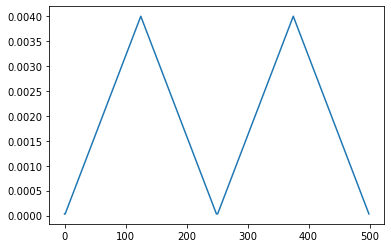

In [171]:
G = create_loosely_connected_hierarchy(num_nodes, num_connections, num_iterations, out_neighborhood, out_connections_p = 0.01)
G = get_largest_component(G)

#### Merged Generation

Finished Connecting Node: 100/500
Finished Connecting Node: 200/500
Finished Connecting Node: 300/500
Finished Connecting Node: 400/500
Finished Connecting Node: 500/500
Finished Connecting Node: 100/500
Finished Connecting Node: 200/500
Finished Connecting Node: 300/500
Finished Connecting Node: 400/500
Finished Connecting Node: 500/500


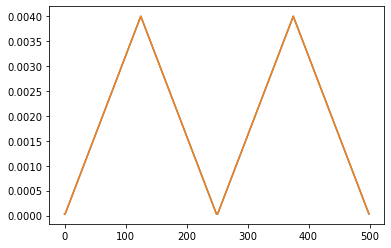

In [153]:
G = create_loosely_connected_hierarchy(num_nodes, num_connections, num_iterations, out_neighborhood)
H = create_loosely_connected_hierarchy(num_nodes, num_connections, num_iterations, out_neighborhood)
G = get_largest_component(G)
H = get_largest_component(H)
size_G = len(G)
size_H = len(H)
# assuming G and H are your two networks
# relabel nodes in H to ensure they are distinct
H = nx.relabel_nodes(H, {node: node + len(G) for node in H.nodes()})

# combine them into a new graph K
K = nx.union(G, H)

G = K.copy()

In [162]:
nodes = list(G.nodes())

# Calculate the index for splitting the nodes list in half
split_index = size_G

# Create two lists of nodes for the subgraphs
nodes = list(G.nodes())
nodes1 = nodes[:split_index]
nodes2 = nodes[split_index:]
subgraph1 = G.subgraph(nodes1)
subgraph2 = G.subgraph(nodes2)
nodes1 = [node for node, degree in subgraph1.degree() if degree <= 1]
nodes2 = [node for node, degree in subgraph2.degree() if degree <= 1]

print("Initial counts:", len(nodes1), len(nodes2))

print("Initial G: Nodes =", G.number_of_nodes(), ", Edges =", G.number_of_edges())

min_length = min(len(nodes1), len(nodes2))

for node1, node2 in zip(nodes1[:min_length], nodes2[:min_length]):
    G.add_edge(node1, node2)

print("After adding edges: Nodes =", G.number_of_nodes(), ", Edges =", G.number_of_edges())
    
# If there are remaining nodes, try to match them with degree 3 nodes
if len(nodes1) > min_length:
    degree3_nodes = [node for node, degree in subgraph2.degree() if degree == 3]
    print('adding to node degree 3 from nodes1')
    for node1, node3 in zip(nodes1[min_length:], degree3_nodes):
        print(node1, node3)
        G.add_edge(node1, node3)
elif len(nodes2) > min_length:
    print('adding to node degree 3 from nodes2')
    degree3_nodes = [node for node, degree in subgraph1.degree() if degree == 3]
    for node2, node3 in zip(nodes2[min_length:], degree3_nodes):
        G.add_edge(node2, node3)
    
print("After adding edges: Nodes =", G.number_of_nodes(), ", Edges =", G.number_of_edges())

Initial counts: 33 25
Initial G: Nodes = 983 , Edges = 1618
After adding edges: Nodes = 983 , Edges = 1643
adding to node degree 3 from nodes1
475 497
479 499
484 501
486 502
487 503
488 507
490 512
491 514
After adding edges: Nodes = 983 , Edges = 1651


### Visualizing Node Degrees

In [172]:
import matplotlib.pyplot as plt

In [173]:
partition_color = False

In [174]:
def k_distrib(graph=G, scale='lin', colour='#40a6d1', alpha=.8, expct_lo=1, expct_hi=10, expct_const=1):
    plt.close()
    num_nodes = graph.number_of_nodes()
    max_degree = 0
    # Calculate the maximum degree to know the range of x-axis
    for n in graph.nodes():
        if graph.degree(n) > max_degree:
            max_degree = graph.degree(n)
    # X-axis and y-axis values
    x = []
    y_tmp = []
    # loop for all degrees until the maximum to compute the portion of nodes for that degree
    for i in range(max_degree):
        x.append(i)
        y_tmp.append(0)
        for n in graph.nodes():
            if graph.degree(n) == i:
                y_tmp[i] += 1
        y = [i/num_nodes for i in y_tmp]
    # Plot the graph
    deg = plt.bar(x, y, label='PMF of Degree distribution')
    plt.title(f'Degree distribution of {len(G.nodes())} Nodes')
    plt.ylabel('P(k)')
    plt.xlabel('k')
    plt.show()

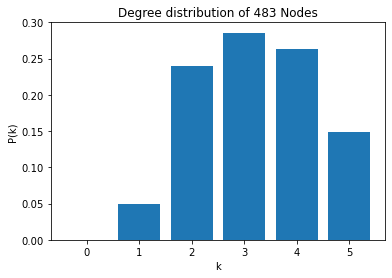

In [175]:
k_distrib(graph=G,colour='#40a6d1', scale='lin',alpha=.8, expct_lo=3, expct_hi=14, expct_const=8)

## Partition

In [176]:
from networkx.algorithms import community

In [177]:
partition_color = True

In [178]:
# Assuming G is your networkx graph
# Using the Girvan-Newman method to detect communities
communities_generator = community.girvan_newman(G)

# Get the first level communities, which is a tuple of sets
first_level_communities = next(communities_generator)

# Create subgraphs from these communities
subgraph1 = G.subgraph(first_level_communities[0])
subgraph2 = G.subgraph(first_level_communities[1])

## Visualize

In [179]:
import plotly.graph_objects as go

In [180]:
Num_nodes = G.number_of_nodes()

#As before we use networkx to determine node positions. We want to do the same spring layout but in 3D
spring_3D = nx.spring_layout(G,dim=3, seed=18)

#we need to seperate the X,Y,Z coordinates for Plotly
x_nodes = [spring_3D[i][0] for i in range(Num_nodes)]# x-coordinates of nodes
y_nodes = [spring_3D[i][1] for i in range(Num_nodes)]# y-coordinates
z_nodes = [spring_3D[i][2] for i in range(Num_nodes)]# z-coordinates

edge_list = G.edges()  # regenerate the edge list

x_edges_black=[]
y_edges_black=[]
z_edges_black=[]

x_edges_gray=[]
y_edges_gray=[]
z_edges_gray=[]

# Iterate over edges
for edge in edge_list:
    # Get edge weight from G
    edge_weight = G[edge[0]][edge[1]].get('weight', 0)
    # Assign coordinates to different lists based on weight
    try:
        if G.edges[edge]["type"] == "intra":
            x_edges_black += [spring_3D[edge[0]][0],spring_3D[edge[1]][0],None]
            y_edges_black += [spring_3D[edge[0]][1],spring_3D[edge[1]][1],None]
            z_edges_black += [spring_3D[edge[0]][2],spring_3D[edge[1]][2],None]
        elif G.edges[edge]["type"] == "inter":
            x_edges_gray += [spring_3D[edge[0]][0],spring_3D[edge[1]][0],None]
            y_edges_gray += [spring_3D[edge[0]][1],spring_3D[edge[1]][1],None]
            z_edges_gray += [spring_3D[edge[0]][2],spring_3D[edge[1]][2],None]
    except:
        x_edges_black += [spring_3D[edge[0]][0],spring_3D[edge[1]][0],None]
        y_edges_black += [spring_3D[edge[0]][1],spring_3D[edge[1]][1],None]
        z_edges_black += [spring_3D[edge[0]][2],spring_3D[edge[1]][2],None]

# Create a trace for the black edges
trace_edges_yellow = go.Scatter3d(
    x=x_edges_black,
    y=y_edges_black,
    z=z_edges_black,
    mode='lines',
    line=dict(color='black', width=3),
    hoverinfo='none'
)

# Create a trace for the gray edges
trace_edges_blue = go.Scatter3d(
    x=x_edges_gray,
    y=y_edges_gray,
    z=z_edges_gray,
    mode='lines',
    line=dict(color='black', width=2),
    hoverinfo='none'
)


# create a list to store the color of each node

color_map = []
for node in G:
    if (partition_color):
        if node in subgraph1:
            color_map.append('red')
        else: # the node is in subgraph2
            color_map.append('blue')
    else:
        color_map.append('red')

#create a trace for the nodes
trace_nodes = go.Scatter3d(x=x_nodes,
                         y=y_nodes,
                        z=z_nodes,
                        mode='markers',
                        marker=dict(symbol='circle',
                                    size=5,
                                    color=color_map, #color the nodes according to their community
                                    line=dict(color='black', width=0.5)),
                        hoverinfo='text')

#we need to set the axis for the plot 
axis = dict(showbackground=False,
            showline=False,
            zeroline=False,
            showgrid=False,
            showticklabels=False,
            title='')

#also need to create the layout for our plot
layout = go.Layout(title="SAN Model",
                width=1650,
                height=1625,
                showlegend=False,
                scene=dict(xaxis=dict(axis),
                        yaxis=dict(axis),
                        zaxis=dict(axis),
                        ),
                margin=dict(t=100),
                hovermode='closest')

#Include the traces we want to plot and create a figure
data = [trace_edges_yellow, trace_edges_blue, trace_nodes]
fig = go.Figure(data=data, layout=layout)

fig.show()

In [274]:
fig.write_html("loose_clusters_topology.html")

In [145]:
A = nx.adjacency_matrix(G)
A_mat = A.todense()
np.savetxt("graph.csv", A_mat.astype(int), fmt='%i', delimiter=",")

C:\Users\home\AppData\Local\Temp\ipykernel_24900\58523056.py:1: FutureWarning:

adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.

